In [1]:
import numpy as np
import pandas as pd
from dataclasses import dataclass




In [2]:
#-------------------------------------------------------------------------------
#---------------------------DataHandler class-----------------------------------
#-------------------------------------------------------------------------------

@dataclass
class DataPoint:
    timestep: int
    E_forecast: float
    E_real: float
    lambda_F: float
    lambda_S: float # UP
    lambda_B: float # DW




In [31]:

#-------------------------------------------------------------------------------
#-------------------------------Online Model Class------------------------------
#-------------------------------------------------------------------------------

class OnlineModel:
    def __init__(self, max_elec_capacity, max_wind_capacity, q_F=np.random.rand(1), q_H=np.random.rand(1), q_adj=np.random.rand(1), lambda_H=92.81682907199999, adj_penalty=10, forget_factor=0.95):
        self.q_F = q_F
        self.q_H = q_H
        self.q_adj = q_adj
        self.lambda_H = lambda_H
        self.adj_penalty = adj_penalty
        self.max_elec_capacity = max_elec_capacity
        self.max_wind_capacity = max_wind_capacity
        self.losses = []
        self.g = np.zeros(3)
        self.forget_factor = forget_factor
        self.lr_const = 0.00001
        self.lr = np.zeros(3) + self.lr_const
        self.calcs = []

    def feasible(self, o, x, cap_up, cap_dw):
        # TODO: Assumes o and x are scalars
        bid = o*x
        if (bid < cap_dw):
            return o + (cap_dw-bid)/x
        elif (bid > cap_up):
            return o +  (cap_up-bid)/x
        else:
            return o

    def get_gradient(self, datapoint: DataPoint, E_S, E_B, x, x_adj):

        if (E_S == 0 and E_B == 0):
            g = [
                - datapoint.lambda_F * x,
                - self.lambda_H * x,
                - self.lambda_H * x_adj
            ]
        elif (E_S == 0):
            g = [
                - datapoint.lambda_F * x + datapoint.lambda_B * x,
                - self.lambda_H * x + datapoint.lambda_B * x,
                - self.lambda_H * x_adj + datapoint.lambda_B * x_adj
            ]
        elif (E_B == 0):
            g = [
                - datapoint.lambda_F * x + datapoint.lambda_S * x,
                - self.lambda_H * x + datapoint.lambda_S * x,
                - self.lambda_H * x_adj + datapoint.lambda_S * x_adj
            ]
        else:
            g = [
                - datapoint.lambda_F * x + datapoint.lambda_S * x + datapoint.lambda_B * x,
                - self.lambda_H * x + datapoint.lambda_S * x + datapoint.lambda_B * x,
                - self.lambda_H * x_adj + datapoint.lambda_S * x_adj + datapoint.lambda_B * x_adj
            ]

        if ((self.q_adj*x_adj) > 0):
                g[2] += x_adj * self.adj_penalty
        elif ((self.q_adj*x_adj) < 0):
                g[2] -= x_adj * self.adj_penalty
        return g


    def step(self, datapoint: DataPoint):

        # 1. Receive features
        # HERE IS SOMETHING NON-GENERIC
        x = np.array([datapoint.E_forecast])
        x_adj = np.array([datapoint.E_real])
        
        # 2. Compute estimators
        E_F = np.dot(self.q_F, x)
        E_H = np.dot(self.q_H, x)
        E_adj = np.dot(self.q_adj, x_adj)
        E_S = np.maximum(datapoint.E_real - E_F - E_H - E_adj, 0)
        E_B = np.maximum(E_F + E_H + E_adj - datapoint.E_real, 0)
        
        # 3. Receive losses
        loss = (datapoint.lambda_F * E_F
            + self.lambda_H * (E_H + E_adj)
            - np.abs(E_adj) * self.adj_penalty
            + datapoint.lambda_S * E_S
            - datapoint.lambda_B * E_B) * (-1)
        self.losses.append(loss)

        self.calcs.append(
            {
                "E_F": E_F,
                "E_H": E_H,
                "E_adj": E_adj,
                "E_B": E_B,
                "E_S": E_S,
                "E_Forecast": datapoint.E_forecast,
                "E_Real": datapoint.E_real,
                "timestep": datapoint.timestep,
                "qF": self.q_F,
                "qH": self.q_H,
                "qAdj": self.q_adj,
                "BuyPrice": datapoint.lambda_B,
                "SellPrice": datapoint.lambda_S,
                "ForwardPrice": datapoint.lambda_F,
                "loss": loss
            }
        )

        # 4. Compute gradient
        g = self.get_gradient(datapoint, E_S, E_B, x, x_adj)

        # 5. Accumulate gradient
        self.acc_gradient(g)

        # 6. Update learning rate
        self.update_lr()

        # 7. Update parameters
        self.update_parameters(x, x_adj)
        

    def acc_gradient(self, g):
        for i in range(len(g)):
            self.g[i] = self.forget_factor*self.g[i] + (1 - self.forget_factor)*(np.abs(g[i]))
        # self.g = g
        

    def update_lr(self):
        # eps = 0.000001
        # for i in range(3):
        #     self.lr[i] = self.lr_const / np.sqrt(self.g[i]+eps)
        pass


    def update_parameters(self, x, x_adj):
        self.q_F = self.feasible(self.q_F - self.lr[0]*self.g[0], x,  self.max_wind_capacity, 0)
        self.q_H = self.feasible(self.q_H - self.lr[1]*self.g[1], x,  self.max_elec_capacity, 0)
        self.q_adj = self.feasible(self.q_adj - self.lr[2]*self.g[2], x_adj,  self.max_elec_capacity - np.dot(self.q_H, x), - np.dot(self.q_H, x))


In [32]:
#-------------------------------------------------------------------------------
#----------------------------------Build Dataset--------------------------------
#-------------------------------------------------------------------------------

df_prices = pd.read_csv("./data/prices_formatted.csv")
df_forecasts = pd.read_csv("./data/forecasts_formatted.csv")
df_realized = pd.read_csv("./data/realized_formatted.csv")

data = [DataPoint(
        E_forecast=df_forecasts.loc[i, "ForecastCurrent"] / 330.0,
        E_real=df_realized.loc[i, "OffshoreWindGe100MW_MWh"] / 330.0,
        lambda_F=df_prices.loc[i, "SpotPriceEUR"],
        lambda_S=df_prices.loc[i, "SpotPriceEUR"]*0.8+np.random.randn(1)/10,
        lambda_B=df_prices.loc[i, "SpotPriceEUR"]*1.2+np.random.randn(1)/10,
        timestep=i
        ) for i in range(df_prices.shape[0])]


In [33]:
#-------------------------------------------------------------------------------
#-------------------------------Define Online Model-----------------------------
#-------------------------------------------------------------------------------
model = OnlineModel(10, 13, lambda_H=100)

In [34]:
#-------------------------------------------------------------------------------
#-------------------------------Train Online Model------------------------------
#-------------------------------------------------------------------------------
for i, datapoint in enumerate(data):
    if (i % 1000 == 0):
        print(f"qF: {model.q_F}, qH: {model.q_H}, qAdj: {model.q_adj}")
    model.step(datapoint)

qF: [0.5561136], qH: [0.29726513], qAdj: [0.10130241]
qF: [0.50679079], qH: [0.], qAdj: [0.]
qF: [0.46738848], qH: [0.], qAdj: [0.]
qF: [0.44189668], qH: [-2.71050543e-20], qAdj: [5.42101086e-20]
qF: [0.41340508], qH: [0.], qAdj: [0.]
qF: [0.39376697], qH: [0.], qAdj: [2.71050543e-20]
qF: [0.38163919], qH: [0.], qAdj: [0.]
qF: [0.37065929], qH: [0.], qAdj: [0.]
qF: [0.34682044], qH: [0.], qAdj: [0.]


In [35]:
#------------------------Check trained parameters

print(model.q_F)
print(model.q_H)
print(model.q_adj)
# print(data[0].E_real)

[0.32765038]
[0.]
[0.]


In [36]:
#------------------------Check some datapoints 

for i in range(3):
    mydict = model.calcs[1000+i]
    print("\n\n")
    print(f"Timestep {mydict['timestep']}")
    print(f"Forward price: {mydict['ForwardPrice']}, Sell price: {mydict['SellPrice']}, Buy price: {mydict['BuyPrice']}")

    print(f"qF: {mydict['qF']}, E_F: {mydict['E_F']}")
    print(f"qH: {mydict['qH']}, E_H: {mydict['E_H']}")



    print(f"qAdj: {mydict['qAdj']}, E_adj: {mydict['E_adj']}")
    # print(f"E_S: {mydict['E_S']} ") # - should be: {np.maximum(mydict['E_Real'] - mydict['E_F'] - mydict['E_H'] - mydict['E_adj'], 0)}")
    # print(f"E_B: {mydict['E_B']} ") # - should be: {np.maximum(mydict['E_F'] + mydict['E_H'] + mydict['E_adj'] - mydict['E_Real'], 0)}")
    print(f"E_S: {mydict['E_S']}, E_B: {mydict['E_B']}  ")

    print(f"E_Forecast: {mydict['E_Forecast']}, E_Real: {mydict['E_Real']}")
    print(f"Loss: {mydict['loss']}")




Timestep 1000
Forward price: 4.14, Sell price: [3.30415668], Buy price: [4.97310943]
qF: [0.50679079], E_F: 0.5379532855793833
qH: [0.], E_H: 0.0
qAdj: [0.], E_adj: 0.0
E_S: 0.5248037083600107, E_B: 0.0  
E_Forecast: 1.0614898666666666, E_Real: 1.062756993939394
Loss: [-3.96116028]



Timestep 1001
Forward price: 2.4, Sell price: [1.92890227], Buy price: [2.86230076]
qF: [0.50673497], E_F: 0.5424367533752266
qH: [0.], E_H: 0.0
qAdj: [0.], E_adj: 0.0
E_S: 0.5317178163217431, E_B: 0.0  
E_Forecast: 1.0704545454545455, E_Real: 1.0741545696969697
Loss: [-2.32747991]



Timestep 1002
Forward price: 1.79, Sell price: [1.24161102], Buy price: [2.1766751]
qF: [0.50668169], E_F: 0.4794283601398224
qH: [0.], E_H: 0.0
qAdj: [0.], E_adj: 0.0
E_S: 0.4759451368298746, E_B: 0.0  
E_Forecast: 0.9462121212121212, E_Real: 0.955373496969697
Loss: [-1.44911549]


In [37]:
#-------------------------------------------------------------------------------
#----------------------------Evaluation class-----------------------------------
#-------------------------------------------------------------------------------

class EvaluationModel:

    def __init__(self, q_F, q_H, q_adj, lambda_H, adj_penalty):
        self.q_F = q_F
        self.q_H = q_H
        self.q_adj = q_adj
        self.lambda_H = lambda_H
        self.adj_penalty = adj_penalty
        self.losses = []
        self.total_loss = 0

    def loss(self, datapoint: DataPoint):
        # 1. Get features
        x = np.array([datapoint.E_forecast])
        x_adj = np.array([datapoint.E_real])
        
        # 2. Compute estimators
        E_F = np.dot(self.q_F, x)
        E_H = np.dot(self.q_H, x)
        E_adj = np.dot(self.q_adj, x_adj)
        E_S = np.maximum(datapoint.E_real - E_F - E_H - E_adj, 0)
        E_B = np.maximum(E_F + E_H + E_adj - datapoint.E_real, 0)
        
        # 3. Receive losses
        loss = (datapoint.lambda_F * E_F
            + self.lambda_H * (E_H + E_adj)
            - np.abs(E_adj) * self.adj_penalty
            + datapoint.lambda_S * E_S
            - datapoint.lambda_B * E_B) * (-1)
        return loss

    def evaluate(self, data):
        self.losses = []
        self.total_loss = 0
        for i, datapoint in enumerate(data):
            loss = self.loss(datapoint)
            self.total_loss += loss
            self.losses.append(loss)

In [38]:
#-------------------------------------------------------------------------------
#-----------------------Evaluate different models-------------------------------
#-------------------------------------------------------------------------------

batch_model = EvaluationModel(
    # q-values from julia
    0.9685614143353147,
    0.0,
    0.0,
    model.lambda_H,
    model.adj_penalty
    )

check_model = EvaluationModel(
    model.q_F,
    model.q_H,
    model.q_adj,
    model.lambda_H,
    model.adj_penalty
)

baseline_model = EvaluationModel(
    0.0,
    0.0,
    0.0,
    model.lambda_H,
    model.adj_penalty
)

forward_model = EvaluationModel(
    1.0,
    0.0,
    0.0,
    model.lambda_H,
    model.adj_penalty
)

batch_model.evaluate(data)
check_model.evaluate(data)
baseline_model.evaluate(data)
forward_model.evaluate(data)

In [39]:
###----------------------Print losses
print("We want the most negative value")
print(f"Forward forecast model: {np.sum(forward_model.losses) }")
print(f"Baseline model: {np.sum(baseline_model.losses) }")
print(f"Online model: {np.sum(check_model.losses)}  ({np.sum(model.losses)})")
print(f"Batch model: {np.sum(batch_model.losses)}")


We want the most negative value
Forward forecast model: -104096.89367103392
Baseline model: -93519.41322992436
Online model: -99146.57250692237  (-105237.16594254662)
Batch model: -104160.18916171801


In [40]:
q_Hs = []
q_Fs = []
q_Adjs = []
for i in range(len(model.losses)):
    mydict = model.calcs[i]
    q_Fs.append(mydict["qF"])
    q_Hs.append(mydict["qH"])
    q_Adjs.append(mydict["qAdj"])


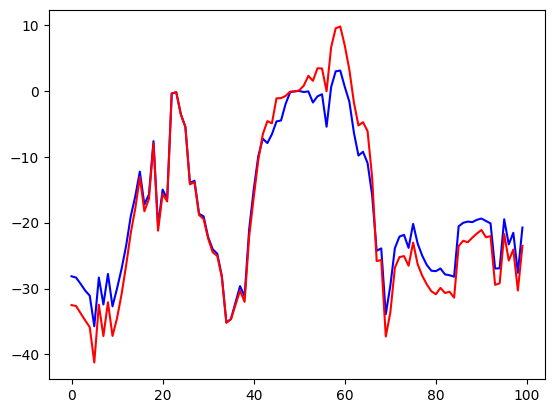

In [46]:
import matplotlib.pyplot as plt

f = plt.figure()
plt.plot(range(100), model.losses[-100:], 'b-')
plt.plot(range(100), forward_model.losses[-100:], 'r-')
plt.show()

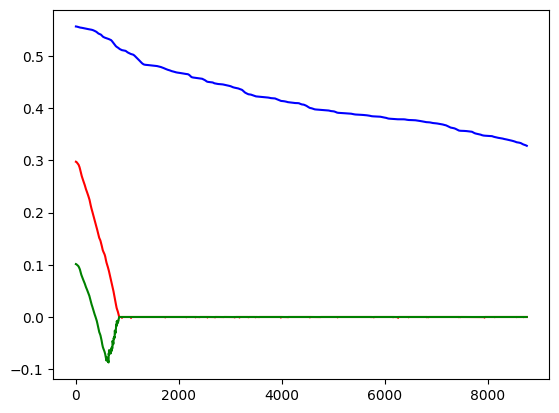

In [42]:
f = plt.figure()
plt.plot(range(len(q_Fs)), q_Fs, 'b-')
plt.plot(range(len(q_Fs)), q_Hs, 'r-')
plt.plot(range(len(q_Fs)), q_Adjs, 'g-')
plt.show()



In [43]:
#---------------------------Check bought and sold amount
total_bought = 0
total_sold = 0
for i in range(len(model.calcs)):
    mydict = model.calcs[i]
    total_bought += np.maximum(batch_model.q_F*mydict['E_Forecast'] + batch_model.q_H*mydict['E_Forecast'] + batch_model.q_adj*mydict['E_Real']- mydict['E_Real'], 0)
    total_sold += np.maximum(mydict['E_Real'] - batch_model.q_F*mydict['E_Forecast'] - batch_model.q_H*mydict['E_Forecast'] - batch_model.q_adj*mydict['E_Real'], 0)
print("Batch model")
print(f"total_bought: {total_bought}")
print(f"total_sold: {total_sold}")
print("")
total_bought = 0
total_sold = 0
for i in range(len(model.calcs)):
    mydict = model.calcs[i]
    total_bought += mydict['E_B']
    total_sold += mydict['E_S']
print("Online model")
print(f"total_bought: {total_bought}")
print(f"total_sold: {total_sold}")
print("")
total_bought = 0
total_sold = 0
for i in range(len(model.calcs)):
    mydict = model.calcs[i]
    # print(f"E_S: {mydict['E_S']}, E_B: {mydict['E_B']}  ")
    # total_bought += np.maximum(mydict['E_Forecast'] - mydict['E_Real'], 0)
    total_sold += np.maximum(mydict['E_Real'], 0)
print("Baseline model")
print(f"total_bought: {total_bought}")
print(f"total_sold: {total_sold}")
print("")
total_bought = 0
total_sold = 0
for i in range(len(model.calcs)):
    mydict = model.calcs[i]
    # print(f"E_S: {mydict['E_S']}, E_B: {mydict['E_B']}  ")
    total_bought += np.maximum(mydict['E_Forecast'] - mydict['E_Real'], 0)
    total_sold += np.maximum(mydict['E_Real'] - mydict['E_Forecast'], 0)
print("Forward model")
print(f"total_bought: {total_bought}")
print(f"total_sold: {total_sold}")

Batch model
total_bought: 1098.9209663412573
total_sold: 1240.1440494757076

Online model
total_bought: 258.71237369746325
total_sold: 2406.693721994996

Baseline model
total_bought: 0
total_sold: 3850.0271992848584

Forward model
total_bought: 1168.945696666669
total_sold: 1189.784512790909


# Results

In [14]:

#-----------------------------------MODEL 1----------------------------
# lambda_H = hydrogen_price
# lambda_UP = [min(l*0.8 + randn()/10, lambda_H-10) for l in lambda_F]
# lambda_DW = [max(l*1.2 + randn()/10, lambda_H+10) for l in lambda_F]
#
# --------------BATCH
# qF: 0.0
# qH: 0.030581372295599277
# qAdj: 0.8748468891101109
#
# Total bought: 140.643724392393
# Total sold: 3788.0541790500743
# Total loss: -322410.62668949
# --------------ONLINE
# qF: 0.31826028
# qH: 0.6426654
# qAdj: 0.84678273
#
# Total bought: 3225.2936871243846
# Total sold: 46.088571203642054
# Total loss: -230095.2372403 ( -225093.08559395222)
# --------------FORWARD
# qF: 1.0
# qH: 0.0
# qAdj: 0.0
#
# Total bought: 1168.945696666669
# Total sold: 1189.784512790909
# Total loss: -12155.722511118587
# --------------BASELINE
# qF: 0.0
# qH: 0.0
# qAdj: 0.0
#
# Total bought: 0.0
# Total sold: 3850.0271992848584
# Total loss: -92636.23720871244
#----------------------------------------------------------------------------

#-----------------------------------MODEL 2----------------------------
# lambda_H = mean(prices)
# lambda_UP = [l*0.8 + randn()/10 for l in lambda_F]
# lambda_DW = [l*1.2 + randn()/10 for l in lambda_F]
#
# --------------BATCH
# qF: 0.9685614143353147
# qH: 0.0
# qAdj: 0.0
#
# Total bought: 1098.9209663412548
# Total sold: 1240.1440495722429
# Total loss: -104156.79991761432
# --------------ONLINE
# qF: 0.94181248 
# qH: 0.83400404 
# qAdj: 0.03650723 
#
# Total bought: 3839.342965765719
# Total sold: 722.9264254221292
# Total loss: -84055.69504119792  (-83659.59031939297)
# --------------FORWARD
# qF: 1.0
# qH: 0.0
# qAdj: 0.0
#
# Total bought: 1168.945696666669
# Total sold: 1189.784512790909
# Total loss: -104093.5110403982
# --------------BASELINE
# qF: 0.0
# qH: 0.0
# qAdj: 0.0
#
# Total bought: 0.0
# Total sold: 3850.0271992848584
# Total loss: -93514.5935036488
#----------------------------------------------------------------------------
